In [464]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [465]:
main_2020 = pd.read_csv('main_2020_all.csv')
print(main_2020.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            18408 non-null  int64  
 1   quarter                         18408 non-null  object 
 2   monthsigned                     18408 non-null  float64
 3   market                          18408 non-null  object 
 4   region                          18408 non-null  object 
 5   city                            18408 non-null  object 
 6   state                           18408 non-null  object 
 7   internal_submarket              18408 non-null  object 
 8   internal_class                  18408 non-null  object 
 9   leasedSF                        18408 non-null  float64
 10  internal_industry               18408 non-null  object 
 11  transaction_type                18408 non-null  object 
 12  space_type                      

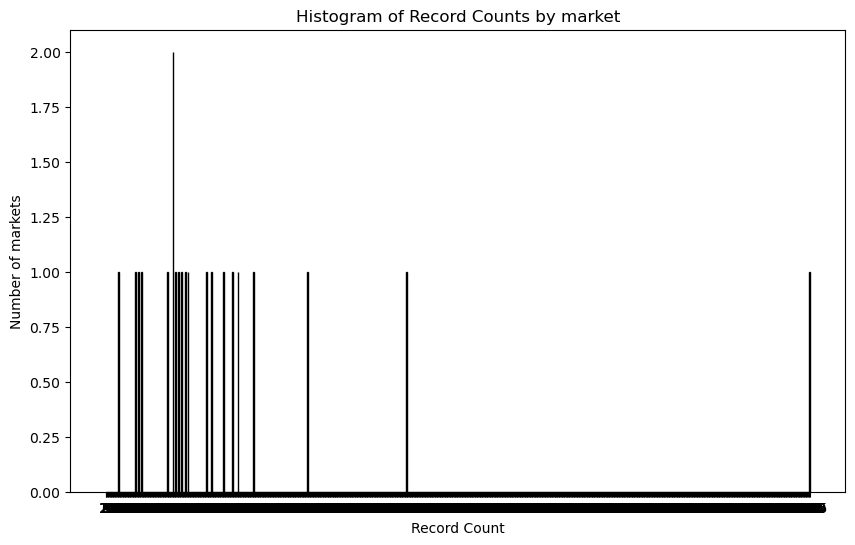

In [466]:
city_counts = main_2020.groupby('market').size().reset_index(name='record_count')

# Define bins with an interval of 10. 
bins = np.arange(0, city_counts['record_count'].max() + 10, 5)

# Create the histogram.
plt.figure(figsize=(10, 6))
plt.hist(city_counts['record_count'], bins=bins, edgecolor='black')
plt.title('Histogram of Record Counts by market')
plt.xlabel('Record Count')
plt.ylabel('Number of markets')
plt.xticks(bins)  # Optional: Set x-ticks to show bin edges
plt.show()

In [467]:
main_2020['quarter_encoded'] = main_2020['quarter'].replace({
    'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4
})

/tmp/ipykernel_1775/3549346842.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_2020['quarter_encoded'] = main_2020['quarter'].replace({


In [468]:
features_for_clustering = [
    "quarter", "market", "internal_submarket", "internal_class", "leasedSF", "state",
    "internal_industry", "transaction_type", "space_type", "CBD_suburban", "RBA",
    "availability_proportion", "internal_class_rent", "overall_rent",
    "direct_availability_proportion", "direct_overall_rent", "sublet_available_space", "leasing"
]

# Identify which columns are categorical vs. numeric.
# You might want to treat columns with values like "Q1", "Atlanta", etc. as categorical.
categorical_columns = [
    "quarter", "market", "internal_submarket", "internal_class", "state",
    "internal_industry", "transaction_type", "space_type", "CBD_suburban"
]
numeric_columns = [
    "leasedSF", "RBA", "availability_proportion", "internal_class_rent", "overall_rent",
    "direct_availability_proportion", "direct_overall_rent", "sublet_available_space", "leasing"
]

# Drop rows with missing values in the selected features.
clustering_df = main_2020.dropna(subset=features_for_clustering).copy()

# Create a ColumnTransformer to encode categorical columns and scale numeric columns.
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
        ("num", StandardScaler(), numeric_columns)
    ]
)

# Apply the transformations to get the final numeric feature matrix for clustering.
X_cluster = preprocessor.fit_transform(clustering_df[features_for_clustering])

# X_cluster is now a numeric array that you can use with your clustering algorithm (e.g., KMeans).
print("Transformed feature matrix shape:", X_cluster.shape)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_df['cluster'] = kmeans.fit_predict(X_cluster)

# -------------------------------
# Merge the cluster labels back into the main_2020 DataFrame.
# This assumes that the index in clustering_df aligns with main_2020.
main_2020 = main_2020.merge(clustering_df[['cluster']], left_index=True, right_index=True, how='left')

# -------------------------------
# Group by 'market' to generate a market value score.

# 1. Count how many records in each market fall into each cluster.
market_cluster_counts = main_2020.groupby('market')['cluster'].value_counts().unstack(fill_value=0)

# 2. Convert the counts to percentages for each market.
market_cluster_pct = market_cluster_counts.div(market_cluster_counts.sum(axis=1), axis=0) * 100

# 3. Define weights for clusters.
# Here we assume a higher cluster number indicates a better market.
cluster_weights = {0: 1, 1: 4, 2: 9}

# 4. Define a function to compute the weighted market score.
def compute_market_score(row, weights):
    # Multiply the percentage for each cluster by its weight and sum the result.
    return sum(row[cluster] * weights[cluster] for cluster in row.index)

# 5. Apply the function to compute a score for each market.
market_scores = market_cluster_pct.apply(lambda row: compute_market_score(row, cluster_weights), axis=1)
market_scores = market_scores.reset_index(name='market_value_score')

# -------------------------------
# Export the market scores to CSV and display the result.
market_scores.to_csv("market_value_score_by_market.csv", index=False)
print(market_scores.head())


Transformed feature matrix shape: (18408, 360)
      market  market_value_score
0    Atlanta          274.298056
1     Austin          196.226415
2  Baltimore          100.000000
3     Boston          158.064516
4  Charlotte          148.387097
